# 多層CNN

* 多層CNNの実装(conv2d, max_pool, dropout)
* Saverを使う

In [1]:
# 必要なモジュールを読み込む
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(20161001)
tf.set_random_seed(20161001)

In [2]:
# MNISTデータを読み込む
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/', one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
# 1層目のConvolution層とPooling層を定義
num_filters1 = 32

x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1, 28, 28, 1])

W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, num_filters1], stddev=0.1))
h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')

b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)

h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [4]:
# 2層目のConvolution層とPooling層を定義
num_filters2 = 64

W_conv2 = tf.Variable(tf.truncated_normal([5, 5, num_filters1, num_filters2]))
h_conv2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')

b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)

h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [5]:
# 全結合層を定義
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])

num_units1 = 7*7*num_filters2
num_units2 = 1024

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)

In [6]:
# ドロップアウト層
keep_prob = tf.placeholder(tf.float32)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

In [7]:
# ソフトマックス層
w0 = tf.Variable(tf.zeros([num_units2, 10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)

In [8]:
# 誤差関数、学習アルゴリズム、正解率を定義
t = tf.placeholder(tf.float32, [None, 10])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
# トレーニングを実施
import time
sess = tf.Session()
sess.run(tf.initialize_all_variables())
saver = tf.train.Saver()

start = time.time()
for i in range(1, 5000+1): # 5,000回トレーニングを実施
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(train_step, feed_dict={ x: batch_xs, t: batch_ts, keep_prob: 0.5 })
    
    # 進捗を表示
    if i % 500 == 0:
        loss_vals, acc_vals = [], []
        for c in range(4):
            start = len(mnist.test.labels) / 4 * c
            end = len(mnist.test.labels) / 4 * (c+1)
            loss_val, acc_val = sess.run([loss, accuracy],
                feed_dict={x:mnist.test.images[start:end],
                           t:mnist.test.labels[start:end],
                           keep_prob:1.0})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))
        saver.save(sess, 'sessions/cnn_session', global_step=i)

elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time / 60), "min")

Step: 500, Loss: 2364.501465, Accuracy: 0.933500
Step: 1000, Loss: 1270.491699, Accuracy: 0.963200
Step: 1500, Loss: 1536.460938, Accuracy: 0.956500
Step: 2000, Loss: 1113.847168, Accuracy: 0.967600
Step: 2500, Loss: 912.800781, Accuracy: 0.974600
Step: 3000, Loss: 887.652161, Accuracy: 0.976800
Step: 3500, Loss: 837.910583, Accuracy: 0.975900
Step: 4000, Loss: 813.723389, Accuracy: 0.977700
Step: 4500, Loss: 741.796204, Accuracy: 0.979400
Step: 5000, Loss: 837.127991, Accuracy: 0.977900
elapsed_time:24588806.237181466 min


# 手書き文字の自動認識アプリ

In [10]:
# セッションにデータをリストア
sess = tf.Session()
sess.run(tf.initialize_all_variables())

saver = tf.train.Saver()
saver.restore(sess, 'sessions/cnn_session-5000')

In [11]:
input_form = """
<table>
  <td style="border-style: none;">
    <div style="border: solid 2px #666; width: 143px; height: 144px;">
    <canvas width="140" height="140"></canvas>
  </td>
  <td style="border-style: none;">
    <button onclick="clear_value()">Clear</button>
  </td>
</table>
"""

javascript = """
<script type="text/javascript">
  var pixels = [];
  for (var i = 0; i < 28*28; i++) pixels[i] = 0;
  var click = 0;

  var canvas = document.querySelector('canvas');
  canvas.addEventListener('mousemove', function(e) {
      if (e.buttons == 1) {
          click = 1;
          canvas.getContext('2d').fillStyle = 'rgb(0,0,0)';
          canvas.getContext('2d').fillRect(e.offsetX, e.offsetY, 8, 8)
          x = Math.floor(e.offsetY * 0.2);
          y = Math.floor(e.offsetX * 0.2) + 1;
          for (var dy = 0; dy < 2; dy++) {
              for (var dx = 0; dx < 2; dx++) {
                  if ((x + dx < 28) && (y + dy < 28)) {
                      pixels[(y+dy) + (x+dx)*28] = 1
                  }
              }
          }
      } else {
          if (click == 1) set_value();
          click = 0;
      }
  });
  
  function set_value() {
      var result = '';
      for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
      var kernel = IPython.notebook.kernel;
      kernel.execute('image = [' + result + ']');
  }
  
  function clear_value() {
      canvas.getContext('2d').fillStyle = 'rgb(255, 255, 255)';
      canvas.getContext('2d').fillRect(0, 0, 140, 140);
      for (var i = 0; i < 28*28; i++) pixels[i] = 0;
   }
</script>
"""

In [16]:
from IPython.display import HTML
HTML(input_form + javascript)

<Container object of 10 artists>

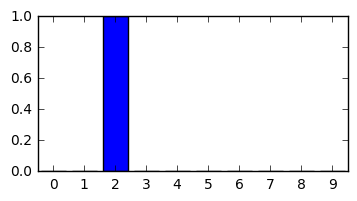

In [17]:
p_val = sess.run(p, feed_dict={ x: [image], keep_prob: 1.0 })
fig = plt.figure(figsize=(4,2))
pred = p_val[0]
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks(range(10))
subplot.set_xlim(-0.5, 9.5)
subplot.set_ylim(0, 1)
subplot.bar(range(10), pred, align='center')